In [ ]:
!pip install datasets -q
!pip install evaluate -q
!pip install wandb -q

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [ ]:
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DefaultDataCollator
)
import torch
import torch.nn.functional as F

In [ ]:
dataset = load_dataset("eljanmahammadli/fake-news-az-en")['train']

In [ ]:
version = "xlm-roberta-base-en-az-fake-news"

id2label = {0: "Real", 1: "Fake"}
label2id = {"Real": 0, "Fake": 1}
num_labels = len(id2label)

per_device_train_batch_size = 16
per_device_eval_batch_size = 16
num_train_epochs = 5
num_saved_models = 100
es_patience = 3

learning_rate = 2e-5
weight_decay = 0.01
warmup_ratio = 0.1

In [ ]:
ds_train_devtest = dataset.train_test_split(test_size=0.2, seed=42)
ds_devtest = ds_train_devtest["test"].train_test_split(test_size=0.5, seed=42)
dataset = DatasetDict(
    {
        "train": ds_train_devtest["train"],
        "valid": ds_devtest["train"],
        "test": ds_devtest["test"],
    }
)

In [ ]:
model_name = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples['news'],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)
train_tokenized = tokenized_dataset["train"]
valid_tokenized = tokenized_dataset["valid"]
test_tokenized = tokenized_dataset["test"]
print("Preparation of dataset is completed!")

Map:   0%|          | 0/16568 [00:00<?, ? examples/s]

Map:   0%|          | 0/2071 [00:00<?, ? examples/s]

Map:   0%|          | 0/2072 [00:00<?, ? examples/s]

Preparation of dataset is completed!


In [ ]:
def compute_metrics(eval_pred):
    metrics = dict()
    accuracy_metric = evaluate.load("accuracy")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric = evaluate.load("f1")
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    metrics.update(accuracy_metric.compute(predictions=predictions, references=labels))
    metrics.update(precision_metric.compute(predictions=predictions, references=labels, average='macro'))
    metrics.update(recall_metric.compute(predictions=predictions, references=labels, average='macro'))
    metrics.update(f1_metric.compute(predictions=predictions, references=labels, average='macro'))
    return metrics

In [ ]:
NUM_GPUS = torch.cuda.device_count() if torch.cuda.is_available() else 1
training_steps = round(
    (
        len(train_tokenized)
        / per_device_train_batch_size
    )
    * num_train_epochs
    / NUM_GPUS
)
log_steps = int(training_steps / num_saved_models)
print(f"Number of training steps: {training_steps}")
data_collator = DefaultDataCollator(return_tensors="pt")

Number of training steps: 5178


In [ ]:
import wandb
import os

wandb.login()

# os.environ["WANDB_PROJECT"] = "fake-news-detection"
wandb.init(project="fake-news-detection", name=version)

training_args = TrainingArguments(
    output_dir=f"./checkpoints/{version}",
    logging_dir=f"./logs/{version}",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=log_steps,
    eval_steps=log_steps,
    use_cpu=False,
    half_precision_backend=True,
    logging_steps=log_steps,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    push_to_hub=True,
    hub_model_id=f"eljanmahammadli/{version}",
    save_safetensors=False,
    report_to="wandb",
    hub_private_repo=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=valid_tokenized,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=int(
                es_patience
            )
        )
    ],
)

trainer.train()
tokenizer.push_to_hub(
    f"eljanmahammadli/{version}"
)
tokenizer.push_to_hub(f"eljanmahammadli/{version}")

wandb: Currently logged in as: elcanmhmmdl. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
51,0.694400,0.691630,0.631579,0.631689,0.631683,0.631579
102,0.690900,0.682713,0.580879,0.735583,0.575921,0.492313
153,0.652900,0.580458,0.870111,0.870095,0.870145,0.870103
204,0.515700,0.369839,0.900048,0.901048,0.900366,0.900024
255,0.377700,0.163714,0.944471,0.944836,0.944317,0.944439
306,0.243100,0.129303,0.955577,0.955700,0.955710,0.955577
357,0.181700,0.146242,0.963303,0.963285,0.963344,0.963300
408,0.192100,0.168695,0.960406,0.961016,0.960656,0.960402


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
51,0.694400,0.691630,0.631579,0.631689,0.631683,0.631579
102,0.690900,0.682713,0.580879,0.735583,0.575921,0.492313
153,0.652900,0.580458,0.870111,0.870095,0.870145,0.870103
204,0.515700,0.369839,0.900048,0.901048,0.900366,0.900024
255,0.377700,0.163714,0.944471,0.944836,0.944317,0.944439
306,0.243100,0.129303,0.955577,0.955700,0.955710,0.955577
357,0.181700,0.146242,0.963303,0.963285,0.963344,0.963300
408,0.192100,0.168695,0.960406,0.961016,0.960656,0.960402
459,0.149100,0.150199,0.969580,0.969884,0.969768,0.969579
510,0.174200,0.092326,0.976823,0.976868,0.976924,0.976823


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eljanmahammadli/xlm-roberta-base-en-az-fake-news/commit/4ce1a30dfee4c080da735ef7dcc5747c91f4a2e5', commit_message='Upload tokenizer', commit_description='', oid='4ce1a30dfee4c080da735ef7dcc5747c91f4a2e5', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# pip install accelerate -U

In [ ]:
# !pip install transformers[torch]
# !pip install accelerate -U

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(f"eljanmahammadli/{version}")
model = AutoModelForSequenceClassification.from_pretrained(f"eljanmahammadli/{version}").to(device)

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/885 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
def predict(text):
    model.eval()
    with torch.no_grad():
        model.eval()
        tokenized_text = tokenizer(
            text, padding="max_length", truncation=True, max_length=512, return_tensors="pt").to(device)
        logits = model(**tokenized_text)['logits']
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
        probs_map = {model.config.id2label[i]: prob for i, prob in enumerate(probs)}
        pred = np.argmax(probs)
        # print(probs, probs_map)
        return pred

predict(input("Enter a text: "))

In [ ]:
import pandas as pd
from tqdm import tqdm

test = dataset['test'].to_pandas()
test.head()
print(test['language'].value_counts())

tqdm.pandas()

test['pred'] = test['news'].progress_apply(predict)
test.head()

language
en    1108
az     964
Name: count, dtype: int64


100%|██████████| 2072/2072 [01:21<00:00, 25.29it/s]


,title,text,label,language,source,news,__index_level_0__,pred
0,Ermənistan T-72 tanklarının müasirləşdirilməsi...,T-72A markalı tank Ermənistan Silahlı Qüvvələr...,0,az,gpt-4o,Ermənistan T-72 tanklarının müasirləşdirilməsi...,5671,0
1,"Exodus of Rohingya to Bangladesh reaches 270,0...","COX S BAZAR, Bangladesh (Reuters) - An estimat...",0,en,GonzaloA,"Exodus of Rohingya to Bangladesh reaches 270,0...",14358,0
2,WOW! COMPANY THAT BUYS ABORTED BABY PARTS FROM...,Last we checked harvesting and selling body pa...,1,en,GonzaloA,WOW! COMPANY THAT BUYS ABORTED BABY PARTS FROM...,16758,1
3,None,Britain's farmers face rising costs if the cou...,1,en,gpt-2,Britain's farmers face rising costs if the cou...,8796,1
4,None,Twenty-five state governments saw their tax re...,1,en,gpt-2,Twenty-five state governments saw their tax re...,13056,1


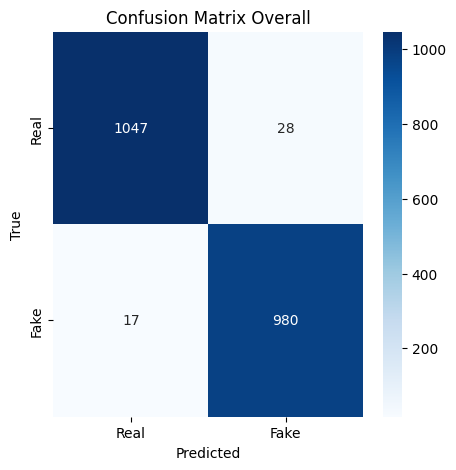

Classification Report Overall
              precision    recall  f1-score   support

        Real       0.98      0.97      0.98      1075
        Fake       0.97      0.98      0.98       997

    accuracy                           0.98      2072
   macro avg       0.98      0.98      0.98      2072
weighted avg       0.98      0.98      0.98      2072

Accuracy Overall: 0.98
F1 Score Overall: 0.98

------------------------------------------------------------



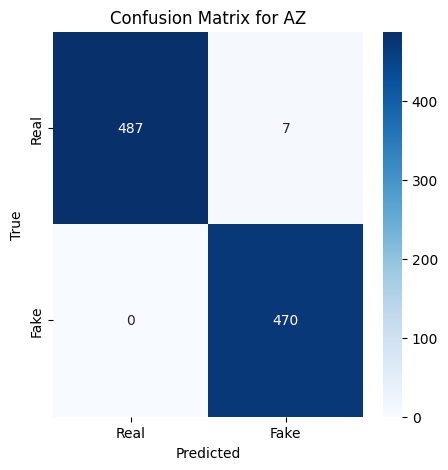

Classification Report for AZ
              precision    recall  f1-score   support

        Real       1.00      0.99      0.99       494
        Fake       0.99      1.00      0.99       470

    accuracy                           0.99       964
   macro avg       0.99      0.99      0.99       964
weighted avg       0.99      0.99      0.99       964

Accuracy for AZ: 0.99
F1 Score for AZ: 0.99

------------------------------------------------------------



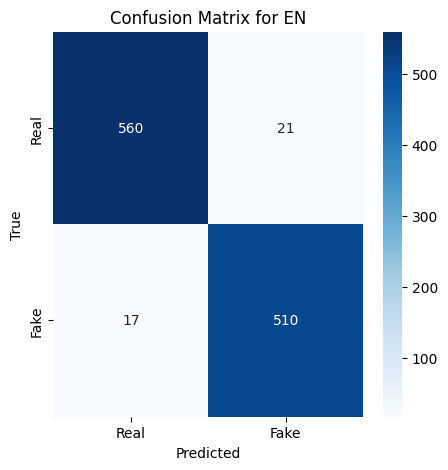

Classification Report for EN
              precision    recall  f1-score   support

        Real       0.97      0.96      0.97       581
        Fake       0.96      0.97      0.96       527

    accuracy                           0.97      1108
   macro avg       0.97      0.97      0.97      1108
weighted avg       0.97      0.97      0.97      1108

Accuracy for EN: 0.97
F1 Score for EN: 0.96

------------------------------------------------------------



In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def evaluate_predictions(df, language=None):
    if language:
        df = df[df['language'] == language]
        title_suffix = f' for {language.upper()}'
    else:
        title_suffix = ' Overall'

    true_labels = df['label']
    pred_labels = df['pred']

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plot_confusion_matrix(cm, list(id2label.values()), f'Confusion Matrix{title_suffix}')

    # Classification Report
    print(f'Classification Report{title_suffix}')
    print(classification_report(true_labels, pred_labels, target_names=list(id2label.values())))

    # Additional Metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    print(f'Accuracy{title_suffix}: {accuracy:.2f}')
    print(f'F1 Score{title_suffix}: {f1:.2f}')
    print()
    print('-' * 60)
    print()

# Evaluate overall
evaluate_predictions(test)

# Evaluate per language
languages = test['language'].unique()
for lang in languages:
    evaluate_predictions(test, language=lang)

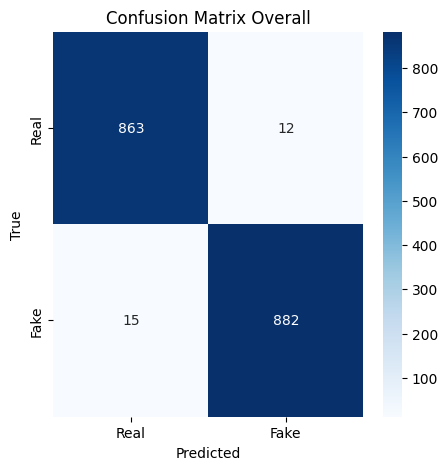

Classification Report Overall
              precision    recall  f1-score   support

        Real       0.98      0.99      0.98       875
        Fake       0.99      0.98      0.98       897

    accuracy                           0.98      1772
   macro avg       0.98      0.98      0.98      1772
weighted avg       0.98      0.98      0.98      1772

Accuracy Overall: 0.98
F1 Score Overall: 0.98

------------------------------------------------------------



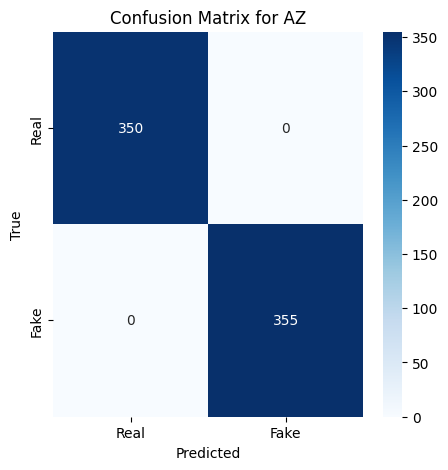

Classification Report for AZ
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00       350
        Fake       1.00      1.00      1.00       355

    accuracy                           1.00       705
   macro avg       1.00      1.00      1.00       705
weighted avg       1.00      1.00      1.00       705

Accuracy for AZ: 1.00
F1 Score for AZ: 1.00

------------------------------------------------------------



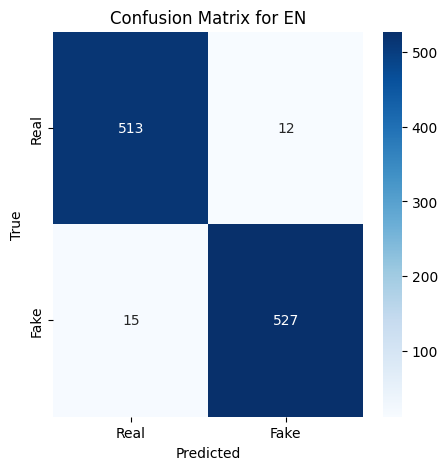

Classification Report for EN
              precision    recall  f1-score   support

        Real       0.97      0.98      0.97       525
        Fake       0.98      0.97      0.98       542

    accuracy                           0.97      1067
   macro avg       0.97      0.97      0.97      1067
weighted avg       0.97      0.97      0.97      1067

Accuracy for EN: 0.97
F1 Score for EN: 0.98

------------------------------------------------------------

